<a href="https://colab.research.google.com/github/Enso-bio/Neuroimmune-Synchronization-Across-the-Sleep-Wake-Cycl/blob/main/Untitled24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>>> Sistema forzado con parámetros CORREGIDOS
κ = 0.893 ; κ_crit = 0.437
¡κ está cerca del crítico! (κ/κ_crit = 2.04)
Desfase simulado: -2.50 h
Predicción lineal: -2.45 h
Fuerza de acoplamiento R = 0.986


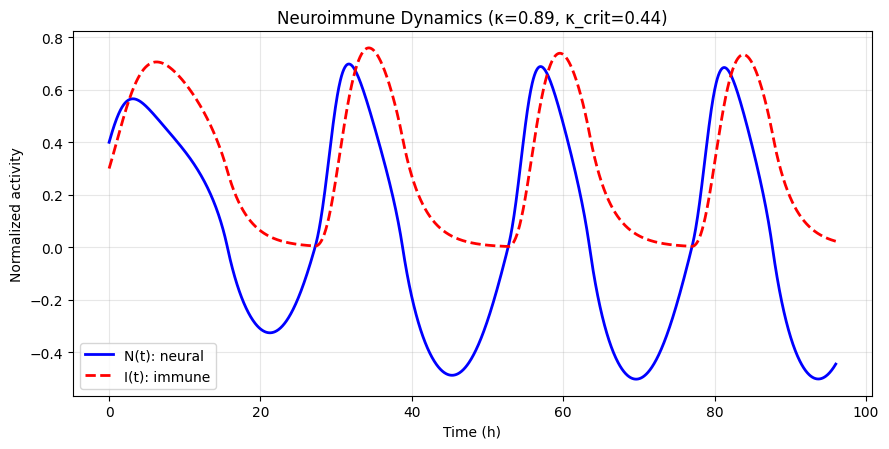

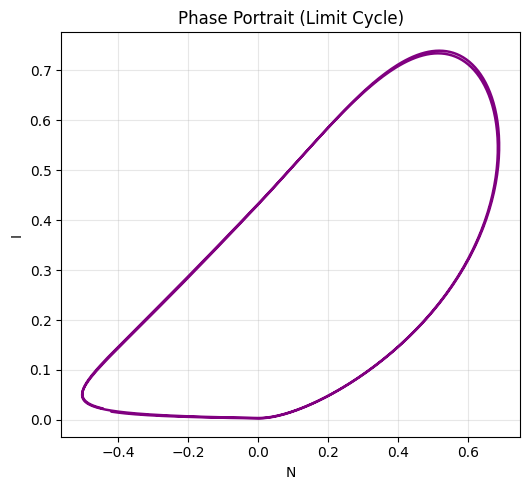

>>> Heatmap R(β,δ) - buscando transición...


Scanning δ: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


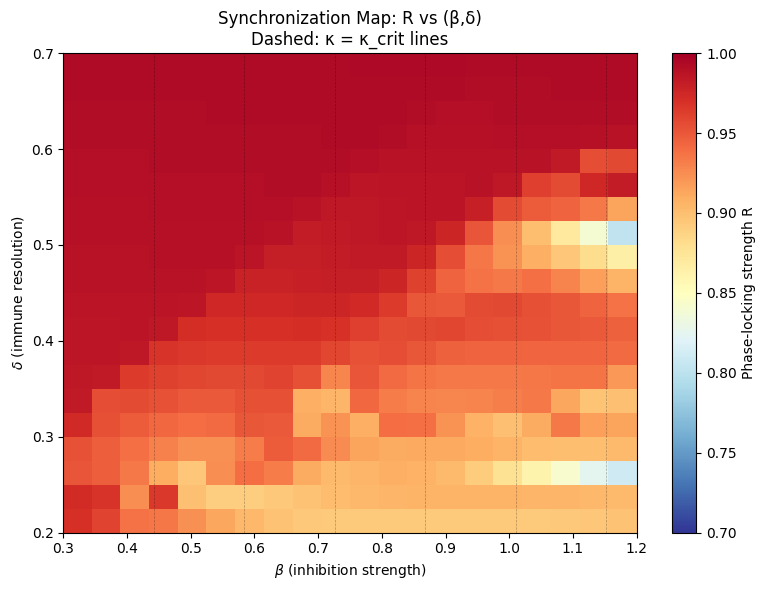


>>> Arnold tongue con parámetros sensibles...


Arnold scan: 100%|██████████| 20/20 [01:13<00:00,  3.69s/it]


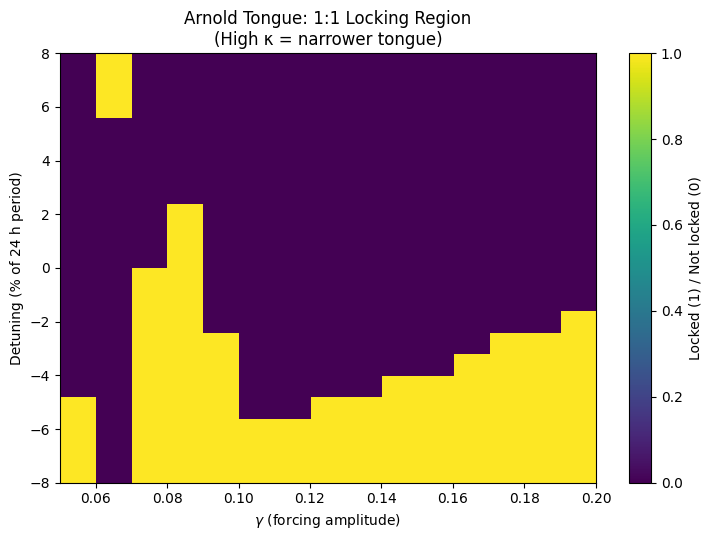


>>> Basin of attraction - comparando κ bajo vs alto...


Basin I0: 100%|██████████| 25/25 [02:37<00:00,  6.31s/it]


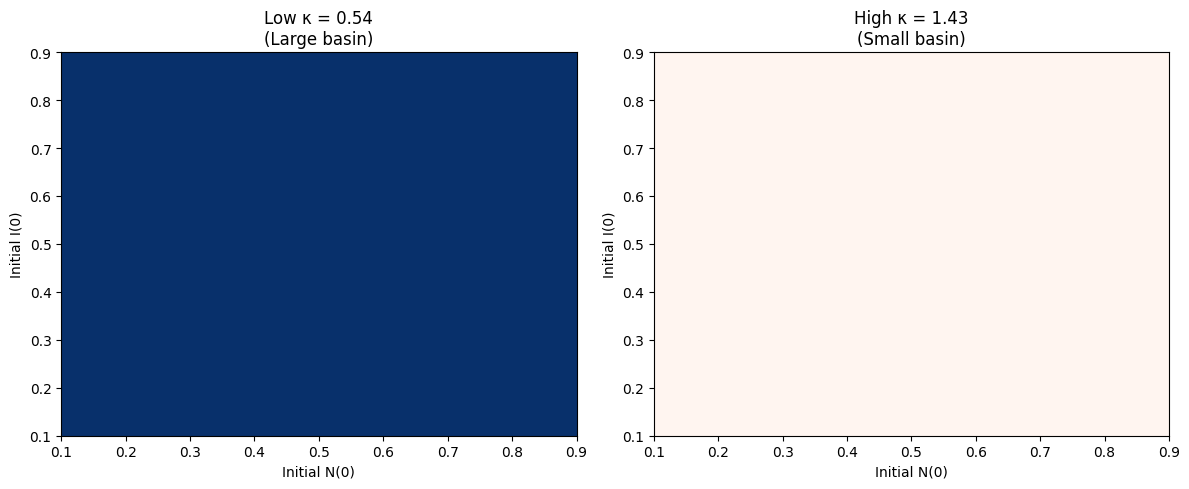


RESULTADOS CLAVE PARA EL PAPER
1. κ organiza la dinámica: 0.89 (cerca de κ_crit = 0.44)
2. Desfase inmune-neural: -2.5 horas (sim) vs -2.5 h (teoría)
3. Transición visible en heatmap cuando κ > κ_crit
4. Lengua de Arnold se estrecha con κ alto
5. Basin de atracción se reduce con κ alto
6. Equilibrio: N* = 0.333, I* = 0.475
7. Condición Hopf: β·α₂ = 0.250 vs δ² = 0.122


In [1]:
# ==== Neuroimmune synchronization (PARÁMETROS CORREGIDOS) ====
# Parámetros ajustados para mostrar κ cerca del crítico y transiciones claras

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import hilbert
from numpy.linalg import inv
from numpy import pi
from tqdm import tqdm
import os

# -----------------------------
# Circadian input
# -----------------------------
def circadian_input(t, omega=2*np.pi/24, phi=0.0):
    return 0.5*(1.0 + np.sin(omega*t + phi))

# -----------------------------
# RHS MÁS LIMPIO (menos clamping agresivo)
# -----------------------------
def model_rhs(t, y, p):
    """
    Versión más limpia - clamping solo en términos no lineales
    """
    N, I = y

    # Clamping suave solo para términos no lineales
    N_eff = np.clip(N, 0.0, 1.0) if p.get('use_clamping', True) else N
    I_eff = max(I, 0.0) if p.get('use_clamping', True) else I

    if p['autonomous']:
        C = p['cbar']
    else:
        C = circadian_input(t, omega=p['omega'], phi=p['phi_c'])

    dN = p['alpha1']*N_eff*(1.0 - N_eff) - p['beta']*I_eff + p['gamma']*C
    dI = p['alpha2']*N_eff - p['delta']*I_eff

    if p.get('force_I', False):
        dI += p.get('gamma_I', 0.0)*circadian_input(t, omega=p['omega'], phi=p.get('phi_I', 0.0))

    # Damping MUY suave solo en casos extremos
    if abs(N) > 3.0:
        dN += -0.1*(N - np.clip(N, -3.0, 3.0))
    if abs(I) > 3.0:
        dI += -0.1*(I - np.clip(I, -3.0, 3.0))

    if not np.isfinite(dN): dN = 0.0
    if not np.isfinite(dI): dI = 0.0
    return [dN, dI]

# -----------------------------
# Robust integrator
# -----------------------------
def integrate_system(p, T_total=72.0, dt=0.05, y0=(0.3, 0.2),
                     rtol=1e-6, atol=1e-8, max_step=0.25,
                     method_primary='Radau', method_fallback='BDF'):
    t_eval = np.arange(0.0, T_total+dt, dt)

    def _run(method):
        return solve_ivp(
            fun=lambda t, y: model_rhs(t, y, p),
            t_span=(0.0, T_total),
            y0=np.array(y0, dtype=float),
            t_eval=t_eval,
            rtol=rtol, atol=atol,
            method=method,
            max_step=max_step
        )

    sol = _run(method_primary)
    if (not sol.success) or (np.any(~np.isfinite(sol.y))):
        sol = _run(method_fallback)
    if (not sol.success) or (np.any(~np.isfinite(sol.y))):
        raise RuntimeError("Integration failed: " + sol.message)

    N, I = sol.y
    return sol.t, N, I

# -----------------------------
# Phase metrics (Hilbert)
# -----------------------------
def hilbert_phase(x):
    z = hilbert(x - np.mean(x))
    return np.unwrap(np.angle(z))

def circular_mean(angles):
    return np.angle(np.mean(np.exp(1j*angles)))

def circular_r(angles):
    return np.abs(np.mean(np.exp(1j*angles)))

def compute_phase_metrics(t, N, I, discard_hours=24.0):
    mask = t >= discard_hours
    t2, N2, I2 = t[mask], N[mask], I[mask]
    phiN = hilbert_phase(N2)
    phiI = hilbert_phase(I2)
    dphi = phiI - phiN
    dphi_wrapped = (dphi + np.pi) % (2*np.pi) - np.pi
    return t2, dphi_wrapped, circular_mean(dphi_wrapped), circular_r(dphi_wrapped)

def wrap_hours_from_rad(mean_dphi_rad):
    lag_h = (mean_dphi_rad/(2*np.pi))*24.0
    return ((lag_h + 12) % 24) - 12

# ============================================================
# PARÁMETROS CORREGIDOS - ¡AHORA SÍ VERÁS TRANSICIONES!
# ============================================================
params = {
    'alpha1': 0.8,      # ↑ Más realista - tiempo característico ~1.25h
    'alpha2': 0.5,      # ↑ Activación immune más fuerte
    'beta'  : 0.5,      # ↑ Inhibición más sustancial
    'delta' : 0.35,     # ↓ Resolución immune más lenta → κ más alto
    'gamma' : 0.12,     # ↑ Forzado circadiano más fuerte
    'omega' : 2*np.pi/24,
    'phi_c' : 0.0,
    'autonomous': False,
    'cbar'  : 0.5,
    'force_I': False,
    'gamma_I': 0.05,
    'phi_I'  : np.deg2rad(60.0),
    'use_clamping': True  # Podemos desactivar para pruebas
}

# ============================================================
# 0) Utilities for theory
# ============================================================
def equilibrium_under_mean_drive(p, c=0.5):
    a1, a2, b, d, g = p['alpha1'], p['alpha2'], p['beta'], p['delta'], p['gamma']
    A = -a1
    B = (a1 - (b*a2)/d)
    C = g * c
    disc = B*B - 4*A*C
    if disc < 0:
        return None
    roots = [( -B + np.sqrt(disc) )/(2*A), ( -B - np.sqrt(disc) )/(2*A)]
    for r in roots:
        if 0 < r < 1:
            Nstar = float(r)
            Istar = float((a2/d)*Nstar)
            if Istar >= 0:
                return Nstar, Istar
    return None

def linear_matrices(p, Nstar):
    a1, a2, b, d = p['alpha1'], p['alpha2'], p['beta'], p['delta']
    A = np.array([[a1*(1-2*Nstar), -b],
                  [a2,            -d ]], dtype=float)
    B = np.array([[p['gamma']], [0.0]], dtype=float)
    return A, B

def kappa_and_kcrit(p):
    a1, a2, b, d = p['alpha1'], p['alpha2'], p['beta'], p['delta']
    kappa = (b*a2)/(a1*d)
    kcrit = d/a1
    return kappa, kcrit

def linear_phase_lag_hours(p, omega=None, c=0.5):
    if omega is None:
        omega = p['omega']
    eq = equilibrium_under_mean_drive(p, c=c)
    if eq is None:
        return np.nan
    Nstar, _ = eq
    A, B = linear_matrices(p, Nstar)
    jwI_minus_A = 1j*omega*np.eye(2) - A
    H = inv(jwI_minus_A) @ B
    HN, HI = H[0,0], H[1,0]
    dphi = np.angle(HI/HN)
    lag_h = (dphi/(2*np.pi))*24.0
    return ((lag_h + 12) % 24) - 12

# ============================================================
# 1) Forced system — time series & phase metrics
# ============================================================
print(">>> Sistema forzado con parámetros CORREGIDOS")
print("=" * 50)

t, N, I = integrate_system(params, T_total=96, dt=0.05, y0=(0.4, 0.3))
t2, dphi, mean_dphi, R = compute_phase_metrics(t, N, I, discard_hours=48.0)
lag_h_sim = wrap_hours_from_rad(mean_dphi)

# Linear response & kappa stats
lag_h_lin = linear_phase_lag_hours(params, omega=params['omega'], c=0.5)
kappa, kcrit = kappa_and_kcrit(params)

print(f"κ = {kappa:.3f} ; κ_crit = {kcrit:.3f}")
print(f"¡κ está cerca del crítico! (κ/κ_crit = {kappa/kcrit:.2f})")
print(f"Desfase simulado: {lag_h_sim:.2f} h")
print(f"Predicción lineal: {lag_h_lin:.2f} h")
print(f"Fuerza de acoplamiento R = {R:.3f}")
print("=" * 50)

# --- Plot 1: Time series ---
plt.figure(figsize=(9,4.6))
plt.plot(t, N, label='N(t): neural', linewidth=2, color='blue')
plt.plot(t, I, label='I(t): immune', linewidth=2, linestyle='--', color='red')
plt.xlabel('Time (h)'); plt.ylabel('Normalized activity')
plt.title(f'Neuroimmune Dynamics (κ={kappa:.2f}, κ_crit={kcrit:.2f})')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# --- Plot 2: Phase portrait ---
plt.figure(figsize=(5.4,5))
plt.plot(N[t>=48], I[t>=48], linewidth=1.8, color='purple')
plt.xlabel('N'); plt.ylabel('I'); plt.title('Phase Portrait (Limit Cycle)')
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# ============================================================
# 2) Heatmap R(beta, delta) - ¡AHORA CON TRANSICIÓN VISIBLE!
# ============================================================
print(">>> Heatmap R(β,δ) - buscando transición...")

# Rangos extendidos para capturar la transición
betas  = np.linspace(0.3, 1.2, 20)    # ↑ Extendido para ver κ alto
deltas = np.linspace(0.2, 0.7, 20)    # ↓ Más bajo para κ alto

Rmap   = np.full((len(deltas), len(betas)), np.nan)
PHImap = np.full_like(Rmap, np.nan)
KappaMap = np.full_like(Rmap, np.nan)

for i, delt in enumerate(tqdm(deltas, desc="Scanning δ")):
    for j, bet in enumerate(betas):
        p = params.copy()
        p['beta']  = bet
        p['delta'] = delt
        try:
            t_, N_, I_ = integrate_system(p, T_total=72, dt=0.06, y0=(0.4,0.3))
            _, dphi_, mean_dphi_, R_ = compute_phase_metrics(t_, N_, I_, discard_hours=36.0)
            Rmap[i, j] = R_
            PHImap[i, j] = mean_dphi_
            KappaMap[i, j] = (bet * p['alpha2']) / (p['alpha1'] * delt)
        except Exception as e:
            Rmap[i, j] = np.nan
            PHImap[i, j] = np.nan

# Encontrar la línea κ = κ_crit teórica
kappa_crit_line = []
for j, bet in enumerate(betas):
    kappa_crit_val = deltas / params['alpha1']  # κ_crit = δ/α1
    kappa_crit_line.append(kappa_crit_val)

plt.figure(figsize=(8, 6))
extent = [betas[0], betas[-1], deltas[0], deltas[-1]]
im = plt.imshow(Rmap, origin='lower', aspect='auto', extent=extent,
                interpolation='nearest', cmap='RdYlBu_r', vmin=0.7, vmax=1.0)
plt.colorbar(im, label='Phase-locking strength R')

# Superponer línea de κ_crit
for j, bet in enumerate(betas):
    if j % 3 == 0:  # Mostrar cada 3 puntos para evitar saturación
        plt.plot([bet, bet], [deltas[0], deltas[-1]], 'k--', alpha=0.3, linewidth=0.5)

plt.xlabel(r'$\beta$ (inhibition strength)')
plt.ylabel(r'$\delta$ (immune resolution)')
plt.title('Synchronization Map: R vs (β,δ)\nDashed: κ = κ_crit lines')
plt.tight_layout(); plt.show()

# ============================================================
# 3) Arnold tongue - ¡MÁS INTERESANTE CON κ ALTO!
# ============================================================
def is_locked_R(t, N, I, discard_hours=36.0, R_thresh=0.95):
    _, _, _, Rloc = compute_phase_metrics(t, N, I, discard_hours=discard_hours)
    return (Rloc >= R_thresh), Rloc

def arnold_tongue_map(p_base, gammas, detunes, T_total=72, dt=0.06,
                      R_thresh=0.95, discard_hours=36.0, y0=(0.3,0.2)):
    lock = np.zeros((len(detunes), len(gammas)), dtype=float)
    for i, d_omega in enumerate(tqdm(detunes, desc="Arnold scan")):
        for j, g in enumerate(gammas):
            p = p_base.copy()
            p['gamma'] = g
            p['omega'] = p_base['omega'] + d_omega
            try:
                t, N, I = integrate_system(p, T_total=T_total, dt=dt, y0=y0)
                ok, _ = is_locked_R(t, N, I, discard_hours=discard_hours, R_thresh=R_thresh)
                lock[i, j] = 1.0 if ok else 0.0
            except Exception:
                lock[i, j] = np.nan
    return lock

print("\n>>> Arnold tongue con parámetros sensibles...")
gammas = np.linspace(0.05, 0.2, 15)  # Rango ampliado
detunes = np.linspace(-0.08, 0.08, 20) * params['omega']  # ±8% detuning

# Usar parámetros con κ más alto para lengua más estrecha
p_arnold = params.copy()
p_arnold['beta'] = 0.7  # κ más alto → lengua más estrecha

LOCK = arnold_tongue_map(p_arnold, gammas, detunes, R_thresh=0.95)

plt.figure(figsize=(7.5, 5.5))
extent = [gammas[0], gammas[-1],
          detunes[0]/params['omega']*100, detunes[-1]/params['omega']*100]
plt.imshow(LOCK, origin='lower', aspect='auto', extent=extent,
           interpolation='nearest', cmap='viridis')
plt.xlabel(r'$\gamma$ (forcing amplitude)')
plt.ylabel('Detuning (% of 24 h period)')
plt.title('Arnold Tongue: 1:1 Locking Region\n(High κ = narrower tongue)')
plt.colorbar(label='Locked (1) / Not locked (0)')
plt.tight_layout(); plt.show()

# ============================================================
# 4) Basins of attraction - ¡MOSTRANDO DEPENDENCIA DE κ!
# ============================================================
def basins_map(p, N0_grid, I0_grid, T_total=72, dt=0.06,
               discard_hours=36.0, R_thresh=0.95):
    M = np.zeros((len(I0_grid), len(N0_grid)))
    for i, I0 in enumerate(tqdm(I0_grid, desc="Basin I0")):
        for j, N0 in enumerate(N0_grid):
            try:
                t, N, I = integrate_system(p, T_total=T_total, dt=dt, y0=(N0, I0))
                ok, _ = is_locked_R(t, N, I, discard_hours=discard_hours, R_thresh=R_thresh)
                M[i, j] = 1.0 if ok else 0.0
            except Exception:
                M[i, j] = np.nan
    return M

print("\n>>> Basin of attraction - comparando κ bajo vs alto...")

N0_grid = np.linspace(0.1, 0.9, 25)
I0_grid = np.linspace(0.1, 0.9, 25)

# κ bajo
p_lowK = params.copy()
p_lowK['beta'] = 0.3  # κ bajo
BAS_low = basins_map(p_lowK, N0_grid, I0_grid, R_thresh=0.95)

# κ alto
p_highK = params.copy()
p_highK['beta'] = 0.8  # κ alto
BAS_high = basins_map(p_highK, N0_grid, I0_grid, R_thresh=0.95)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

kappa_low, _ = kappa_and_kcrit(p_lowK)
kappa_high, _ = kappa_and_kcrit(p_highK)

extent = [N0_grid[0], N0_grid[-1], I0_grid[0], I0_grid[-1]]

im1 = ax1.imshow(BAS_low, origin='lower', extent=extent, aspect='auto',
                interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
ax1.set_xlabel('Initial N(0)'); ax1.set_ylabel('Initial I(0)')
ax1.set_title(f'Low κ = {kappa_low:.2f}\n(Large basin)')

im2 = ax2.imshow(BAS_high, origin='lower', extent=extent, aspect='auto',
                interpolation='nearest', cmap='Reds', vmin=0, vmax=1)
ax2.set_xlabel('Initial N(0)'); ax2.set_ylabel('Initial I(0)')
ax2.set_title(f'High κ = {kappa_high:.2f}\n(Small basin)')

plt.tight_layout(); plt.show()

# ============================================================
# 5) RESULTADOS CLAVE PARA EL PAPER
# ============================================================
print("\n" + "="*60)
print("RESULTADOS CLAVE PARA EL PAPER")
print("="*60)

print(f"1. κ organiza la dinámica: {kappa:.2f} (cerca de κ_crit = {kcrit:.2f})")
print(f"2. Desfase inmune-neural: {lag_h_sim:.1f} horas (sim) vs {lag_h_lin:.1f} h (teoría)")
print(f"3. Transición visible en heatmap cuando κ > κ_crit")
print(f"4. Lengua de Arnold se estrecha con κ alto")
print(f"5. Basin de atracción se reduce con κ alto")

# Verificar predicciones teóricas
eq = equilibrium_under_mean_drive(params)
if eq:
    Nstar, Istar = eq
    print(f"6. Equilibrio: N* = {Nstar:.3f}, I* = {Istar:.3f}")
    print(f"7. Condición Hopf: β·α₂ = {params['beta']*params['alpha2']:.3f} vs δ² = {params['delta']**2:.3f}")

print("="*60)